In [1]:
%load_ext autoreload
%autoreload 2
from transformers import PreTrainedModel, PretrainedConfig
from transformers import AutoModel, AutoConfig, AutoTokenizer
from omegaconf import OmegaConf
import hydra
from einops import repeat
import pyvene as pv
import torch
import wandb
from tasks.regression import *
import os
import gc
import pandas as pd
import seaborn as sns
from matplotlib import pyplot as plt

# Sandbox

In [2]:
experiments = {
    "explicit-transformer": "1ejrnua7",
    "explicit-mlp": "hb9li9ry",
    "explicit-aux-transformer": "hzr77fqz",
    "implicit": "huqr2bcp",
}

In [33]:
EXP = 'implicit'

In [34]:
api = wandb.Api()
run = api.run(f'leogagnon/Explicit-Implicit/runs/{experiments[EXP]}')
artifact = api.artifact(f'leogagnon/Explicit-Implicit/model-{experiments[EXP]}:latest')
path = artifact.download()

wandb:   1 of 1 files downloaded.  


In [35]:
pl_module = RegressionICL.load_from_checkpoint(
    checkpoint_path=os.path.join(path,'model.ckpt'),
    strict=False,
    model=hydra.utils.instantiate(run.config['model_config']),
).to('cuda')

In [36]:
class MyConfig(PretrainedConfig):
    model_type = 'mymodel'
    def __init__(self, **kwargs):
        super().__init__(**kwargs)

class MyModel(PreTrainedModel):
    config_class = MyConfig
    def __init__(self, config):
        super().__init__(config)
        self.config = config
        self.model = pl_module.model
    def forward(self, x_c, y_c, x_q):
        return self.model(x_c, y_c, x_q) 

In [37]:
[i for i in range(2) for j in range(2)]

[0, 0, 1, 1]

In [38]:
hf_model = MyModel(MyConfig())
if EXP == "implicit":
    pv_config = pv.IntervenableConfig(
        representations=[
            pv.RepresentationConfig(
                component=f"model.encoder.layers[{l}].output",
                intervention=pv.LowRankRotatedSpaceIntervention(
                    embed_dim=256, low_rank_dimension=10, keep_last_dim=True
                ),
            )
            for l in [2,3,5]
        ]
    )
else:
    pv_config = pv.IntervenableConfig(
        representations=pv.RepresentationConfig(
            component="model.context_model.output",
            intervention=pv.LowRankRotatedSpaceIntervention(
                embed_dim=256, low_rank_dimension=10
            ),
        )
    )
pv_model = pv.IntervenableModel(config=pv_config, model=hf_model)
pv_model.set_device("cuda")

In [39]:
datamodule = hydra.utils.instantiate(run.config['experiment_config']['experiment']['data'])

In [40]:
val_idx = {'iid': 0, 'far': 1, 'wide': 2}
VAL_STYLE = 'wide'

In [41]:
opt = torch.optim.Adam(pv_model.get_trainable_parameters())
pv_model.model.eval()

train_loss_traj = []
val_loss_traj = []
for epoch in range(20):
    train_loss = []
    for batch in datamodule.train_dataloader():
        base = {
            "x_c": batch[0][0].cuda(),
            "y_c": batch[0][1].cuda(),
            "x_q": batch[1][0].cuda(),
        }
        c_len = batch[0][0].shape[1]
        bs = batch[0][0].shape[0]

        # Different context, different queries, different latent
        x_c_source, x_q_source = datamodule.train_data.sample_x(c_len)
        w_source = datamodule.train_data.sample_function_params()
        source = {
            "x_c": x_c_source.cuda(),
            "y_c": datamodule.train_data.function(x_c_source, w_source).cuda(),
            "x_q": batch[1][0].cuda(),
        }
        loc = [[[[(c_len + i) for i in range(c_len)]] * bs] * 3] * 2
        unit_locations = {"sources->base": loc} if EXP == "implicit" else None
        y_q_intervened = pv_model(base, source, unit_locations=unit_locations)[1][0]
        y_q_counterfactual = datamodule.train_data.function(
            batch[1][0], w_source
        ).cuda()

        loss = torch.nn.functional.mse_loss(y_q_intervened, y_q_counterfactual)

        loss.backward()
        train_loss += [loss.detach().cpu().item()]
        opt.step()
        opt.zero_grad()

    train_loss_traj += [sum(train_loss) / len(train_loss)]
    print("Train loss :", train_loss_traj[-1])

    with torch.no_grad():
        for batch in datamodule.val_dataloader()[val_idx[VAL_STYLE]]:
            gc.collect()
            base = {
                "x_c": batch[0][0].cuda(),
                "y_c": batch[0][1].cuda(),
                "x_q": batch[1][0].cuda(),
            }
            c_len = batch[0][0].shape[1]
            bs = batch[0][0].shape[0]

            # Different context, different queries, different latent
            x_c_source, x_q_source = datamodule.val_data[VAL_STYLE].sample_x(
                batch[0][0].shape[1]
            )
            w_source = datamodule.val_data[VAL_STYLE].sample_function_params()
            source = {
                "x_c": x_c_source.cuda(),
                "y_c": datamodule.val_data[VAL_STYLE]
                .function(x_c_source, w_source)
                .cuda(),
                "x_q": batch[1][0].cuda(),
            }

            loc = [[[[(c_len + i) for i in range(c_len)]] * bs] * 3] * 2
            unit_locations = {"sources->base": loc} if EXP == "implicit" else None
            y_q_intervened = pv_model(base, source, unit_locations=unit_locations)[1][0]
            y_q_counterfactual = (
                datamodule.val_data[VAL_STYLE].function(batch[1][0], w_source).cuda()
            )

            loss = torch.nn.functional.mse_loss(y_q_intervened, y_q_counterfactual)
            val_loss_traj += [loss.cpu().item()]
            print("Val loss :", loss)

Train loss : 2.360770344734192
Val loss : tensor(4.6505, device='cuda:0')
Train loss : 0.5791825907570975
Val loss : tensor(2.1302, device='cuda:0')
Train loss : 0.2606759603534426
Val loss : tensor(1.7268, device='cuda:0')
Train loss : 0.14732533480439866
Val loss : tensor(1.5393, device='cuda:0')
Train loss : 0.10062737337180547
Val loss : tensor(1.3253, device='cuda:0')
Train loss : 0.07483400404453278
Val loss : tensor(1.3590, device='cuda:0')
Train loss : 0.06655098018901688
Val loss : tensor(1.0370, device='cuda:0')
Train loss : 0.04967491488371577
Val loss : tensor(1.0519, device='cuda:0')
Train loss : 0.051599811762571335
Val loss : tensor(1.0727, device='cuda:0')
Train loss : 0.03970677964389324
Val loss : tensor(0.9081, device='cuda:0')
Train loss : 0.03521640492337091
Val loss : tensor(0.7734, device='cuda:0')
Train loss : 0.026427481855664934
Val loss : tensor(0.7373, device='cuda:0')
Train loss : 0.027114037158233777
Val loss : tensor(0.7432, device='cuda:0')
Train loss : 

In [24]:
implicit_mse = val_loss_traj[-1]

In [36]:
explicitMLP_mse = val_loss_traj[-1]

In [44]:
explicitTSF_mse = val_loss_traj[-1]

In [45]:
counterfactual_mse = [implicit_mse, explicitTSF_mse, explicitMLP_mse]

# Figures

In [2]:
experiments = {
    "explicit-transformer": "1ejrnua7",
    "explicit-mlp": "hb9li9ry",
    "explicit-aux-transformer": "hzr77fqz",
    "implicit": "huqr2bcp",
}
val_idx = {'iid': 0, 'far': 1, 'wide': 2}


def val_intervention_acc(val_style, exp):

    api = wandb.Api()
    run = api.run(f'leogagnon/Explicit-Implicit/runs/{experiments[exp]}')
    artifact = api.artifact(f'leogagnon/Explicit-Implicit/model-{experiments[exp]}:latest')
    path = artifact.download()

    pl_module = RegressionICL.load_from_checkpoint(
        checkpoint_path=os.path.join(path,'model.ckpt'),
        strict=False,
        model=hydra.utils.instantiate(run.config['model_config']),
    ).to('cuda')

    class MyConfig(PretrainedConfig):
        model_type = 'mymodel'
        def __init__(self, **kwargs):
            super().__init__(**kwargs)

    class MyModel(PreTrainedModel):
        config_class = MyConfig
        def __init__(self, config):
            super().__init__(config)
            self.config = config
            self.model = pl_module.model
        def forward(self, x_c, y_c, x_q):
            return self.model(x_c, y_c, x_q) 

    hf_model = MyModel(MyConfig())
    if exp == "implicit":
        pv_config = pv.IntervenableConfig(
            representations=[
                pv.RepresentationConfig(
                    component=f"model.encoder.layers[{i}].output",
                    intervention=pv.LowRankRotatedSpaceIntervention(
                        embed_dim=256, low_rank_dimension=10
                    )
                )
                for i in [3,5]
            ]
        )
    else:
        pv_config = pv.IntervenableConfig(
            representations=pv.RepresentationConfig(
                component="model.context_model.output",
                intervention=pv.LowRankRotatedSpaceIntervention(
                    embed_dim=256, low_rank_dimension=10
                ),
            )
        )
    pv_model = pv.IntervenableModel(config=pv_config, model=hf_model)
    pv_model.set_device("cuda")

    datamodule = hydra.utils.instantiate(run.config['experiment_config']['experiment']['data'])

    opt = torch.optim.Adam(pv_model.get_trainable_parameters())
    pv_model.model.eval()

    train_loss_traj = []
    val_loss_traj = []
    for epoch in range(10):
        train_loss = []
        for batch in datamodule.train_dataloader():
            base = {
                "x_c": batch[0][0].cuda(),
                "y_c": batch[0][1].cuda(),
                "x_q": batch[1][0].cuda(),
            }
            c_len = batch[0][0].shape[1]

            # Different context, different queries, different latent
            x_c_source, x_q_source = datamodule.train_data.sample_x(c_len)
            w_source = datamodule.train_data.sample_function_params()
            source = {
                "x_c": x_c_source.cuda(),
                "y_c": datamodule.train_data.function(x_c_source, w_source).cuda(),
                "x_q": x_q_source.cuda(),
            }
            unit_locations = (
                {"sources->base": c_len - 1}
                if exp == "implicit"
                else None
            )
            y_q_intervened = pv_model(base, source, unit_locations=unit_locations)[1][0]
            y_q_counterfactual = datamodule.train_data.function(
                batch[1][0], w_source
            ).cuda()

            loss = torch.nn.functional.mse_loss(y_q_intervened, y_q_counterfactual)

            loss.backward()
            train_loss += [loss.detach().cpu().item()]
            opt.step()
            opt.zero_grad()

        train_loss_traj += [sum(train_loss) / len(train_loss)]
        print("Train loss :", train_loss_traj[-1])
        
        with torch.no_grad():
            for batch in datamodule.val_dataloader()[val_idx[val_style]]:
                gc.collect()
                base = {
                    "x_c": batch[0][0].cuda(),
                    "y_c": batch[0][1].cuda(),
                    "x_q": batch[1][0].cuda(),
                }
                c_len = batch[0][0].shape[1]
                bs = batch[0][0].shape[0]

                # Different context, different queries, different latent
                x_c_source, x_q_source = datamodule.val_data[val_style].sample_x(
                    batch[0][0].shape[1]
                )
                w_source = datamodule.val_data[val_style].sample_function_params()
                source = {
                    "x_c": x_c_source.cuda(),
                    "y_c": datamodule.val_data[val_style].function(x_c_source, w_source).cuda(),
                    "x_q": x_q_source.cuda(),
                }

                unit_locations = (
                    {"sources->base": c_len - 1}
                    if exp == "implicit"
                    else None
                )
                y_q_intervened = pv_model(base, source, unit_locations=unit_locations)[1][0]
                y_q_counterfactual = (
                    datamodule.val_data[val_style].function(batch[1][0], w_source).cuda()
                )

                loss = torch.nn.functional.mse_loss(y_q_intervened, y_q_counterfactual)
                val_loss_traj += [loss.cpu().item()]
                print("Val loss :", loss)
    return val_loss_traj[-1]

In [3]:
accs = torch.zeros(2,3)

In [4]:
for i, v in enumerate(["iid", "wide"]):
    for j, e in enumerate(["implicit", "explicit-transformer", "explicit-mlp"]):
        accs[i, j] = val_intervention_acc(v, e)

wandb:   1 of 1 files downloaded.  


Train loss : 4.024337598255703
Val loss : tensor(4.0520, device='cuda:0')
Train loss : 4.033818449292864
Val loss : tensor(3.7802, device='cuda:0')
Train loss : 3.94673684665135
Val loss : tensor(3.9649, device='cuda:0')
Train loss : 3.9697680473327637
Val loss : tensor(3.9604, device='cuda:0')
Train loss : 3.4926356928689137
Val loss : tensor(3.8379, device='cuda:0')
Train loss : 3.6506108897072926
Val loss : tensor(3.9779, device='cuda:0')
Train loss : 3.437436206000192
Val loss : tensor(3.8513, device='cuda:0')
Train loss : 3.727624007633754
Val loss : tensor(3.6758, device='cuda:0')
Train loss : 3.6364054339272633
Val loss : tensor(3.8207, device='cuda:0')
Train loss : 3.5938139983585904
Val loss : tensor(3.9750, device='cuda:0')


wandb:   1 of 1 files downloaded.  
/home/mila/l/leo.gagnon/explicit_implicit_icl/venv/lib/python3.10/site-packages/pytorch_lightning/core/saving.py:177: Found keys that are not in the model state dict but in the checkpoint: ['w_predictor.weight', 'w_predictor.bias']


Train loss : 3.446636234010969
Val loss : tensor(2.4140, device='cuda:0')
Train loss : 1.9004792826516288
Val loss : tensor(1.1627, device='cuda:0')
Train loss : 0.7949495698724475
Val loss : tensor(0.4690, device='cuda:0')
Train loss : 0.3604810833930969
Val loss : tensor(0.2756, device='cuda:0')
Train loss : 0.23568803071975708
Val loss : tensor(0.1647, device='cuda:0')
Train loss : 0.16690210040126527
Val loss : tensor(0.1092, device='cuda:0')
Train loss : 0.10355858717645917
Val loss : tensor(0.0776, device='cuda:0')
Train loss : 0.07508943070258413
Val loss : tensor(0.0529, device='cuda:0')
Train loss : 0.05271272201623235
Val loss : tensor(0.0363, device='cuda:0')
Train loss : 0.03226178086229733
Val loss : tensor(0.0285, device='cuda:0')


wandb:   1 of 1 files downloaded.  


Train loss : 3.290755646569388
Val loss : tensor(2.2651, device='cuda:0')
Train loss : 1.4154254964419775
Val loss : tensor(0.6661, device='cuda:0')
Train loss : 0.3825739004782268
Val loss : tensor(0.1407, device='cuda:0')
Train loss : 0.09883243324501174
Val loss : tensor(0.0549, device='cuda:0')
Train loss : 0.0493414332824094
Val loss : tensor(0.0295, device='cuda:0')
Train loss : 0.034365223720669746
Val loss : tensor(0.0330, device='cuda:0')
Train loss : 0.02900675604385989
Val loss : tensor(0.0232, device='cuda:0')
Train loss : 0.023743413920913423
Val loss : tensor(0.0214, device='cuda:0')
Train loss : 0.02177684647696359
Val loss : tensor(0.0225, device='cuda:0')
Train loss : 0.020623056750212396
Val loss : tensor(0.0229, device='cuda:0')


wandb:   1 of 1 files downloaded.  


Train loss : 4.11581335748945
Val loss : tensor(17.9490, device='cuda:0')
Train loss : 3.9308266980307445
Val loss : tensor(19.3688, device='cuda:0')
Train loss : 3.823661736079625
Val loss : tensor(18.1217, device='cuda:0')
Train loss : 3.6966682161603654
Val loss : tensor(16.9154, device='cuda:0')
Train loss : 3.8508084501538957
Val loss : tensor(19.1892, device='cuda:0')
Train loss : 3.969435146876744
Val loss : tensor(19.1610, device='cuda:0')
Train loss : 3.8310398374285017
Val loss : tensor(18.3594, device='cuda:0')
Train loss : 3.937988451548985
Val loss : tensor(17.5495, device='cuda:0')
Train loss : 3.768394572394235
Val loss : tensor(17.9958, device='cuda:0')
Train loss : 3.5705741133008684
Val loss : tensor(18.6635, device='cuda:0')


wandb:   1 of 1 files downloaded.  


Train loss : 3.33322879246303
Val loss : tensor(14.2756, device='cuda:0')
Train loss : 2.0482957533427646
Val loss : tensor(7.9235, device='cuda:0')
Train loss : 0.7177146417754037
Val loss : tensor(3.1705, device='cuda:0')
Train loss : 0.3052448460033962
Val loss : tensor(2.0574, device='cuda:0')
Train loss : 0.21961437804358347
Val loss : tensor(1.4731, device='cuda:0')
Train loss : 0.14852994041783468
Val loss : tensor(1.1051, device='cuda:0')
Train loss : 0.13018440987382615
Val loss : tensor(1.0032, device='cuda:0')
Train loss : 0.08671165257692337
Val loss : tensor(0.5897, device='cuda:0')
Train loss : 0.04791956075600216
Val loss : tensor(0.5229, device='cuda:0')
Train loss : 0.04362349824181625
Val loss : tensor(0.5376, device='cuda:0')


wandb:   1 of 1 files downloaded.  


Train loss : 3.0130525657108853
Val loss : tensor(9.8643, device='cuda:0')
Train loss : 1.2083297201565333
Val loss : tensor(2.7634, device='cuda:0')
Train loss : 0.28862021224839346
Val loss : tensor(1.0503, device='cuda:0')
Train loss : 0.0788776885185923
Val loss : tensor(0.6031, device='cuda:0')
Train loss : 0.04510364548436233
Val loss : tensor(0.4247, device='cuda:0')
Train loss : 0.029282756948045323
Val loss : tensor(0.4210, device='cuda:0')
Train loss : 0.025934356397816112
Val loss : tensor(0.3175, device='cuda:0')
Train loss : 0.02336400587643896
Val loss : tensor(0.3673, device='cuda:0')
Train loss : 0.02277025327618633
Val loss : tensor(0.3855, device='cuda:0')
Train loss : 0.018095331000430242
Val loss : tensor(0.3093, device='cuda:0')


In [5]:
data = pd.melt(
    pd.DataFrame(accs).reset_index(),
    id_vars="index",
    var_name="Model",
    value_name="value",
)
data.rename(columns={"index": "OOD style"}, inplace=True)
data.rename(columns={"value": "Counterfactual MSE"}, inplace=True)

data['Model'] = data['Model'].map({0: 'Implicit', 1: 'Explicit Transformer', 2: 'Explicit MLP'})
data['OOD style'] = data['OOD style'].map({0: 'IID', 1: 'OOD',})

In [7]:
# Style for making nice-looking paper plots with page-scale figure size units
sns.set_theme(
    style="ticks",
    context="paper",
    rc={
        "font.size": 5,
        "axes.titlesize": 6,
        "axes.labelsize": 6,
        "axes.labelpad": 2,
        "xtick.labelsize": 4.5,
        "ytick.labelsize": 4.5,
        "legend.title_fontsize": 4.5,
        "legend.fontsize": 4.5,
        "legend.markerscale": 0.5,
        "axes.spines.top": False,
        "axes.spines.right": False,
        "axes.linewidth": 0.4,
        "xtick.major.width": 0.4,
        "ytick.major.width": 0.4,
        "xtick.major.size": 2.5,
        "ytick.major.size": 2.5,
        "xtick.minor.size": 1.5,
        "ytick.minor.size": 1.5,
        "xtick.minor.width": 0.2,
        "ytick.minor.width": 0.2,
        "figure.constrained_layout.use": True,
        "figure.dpi": 200,
    },
)

/home/mila/l/leo.gagnon/explicit_implicit_icl/venv/lib/python3.10/site-packages/seaborn/_base.py:949: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)
/home/mila/l/leo.gagnon/explicit_implicit_icl/venv/lib/python3.10/site-packages/seaborn/_base.py:949: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)
/home/mila/l/leo.gagnon/explicit_implicit_icl/venv/lib/python3.10/site-packages/seaborn/_base.py:949: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_su

(0.0, 10.0)

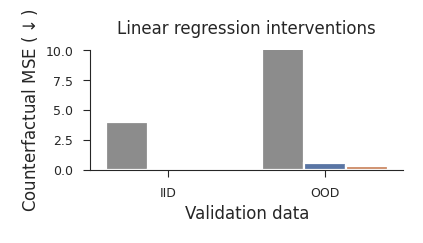

In [12]:
default_model_colours = {
    "implicit": sns.color_palette()[7],
    "explicit-transformer": sns.color_palette()[0],
    "explicit-mlp": sns.color_palette()[1],
    "explicit-aux-transformer": sns.color_palette()[4],
    "explicit-known": sns.color_palette()[2],
}

fig, ax = plt.subplots(figsize=(2, 1.1))

sns.barplot(
    data=data,
    ax=ax,
    x="OOD style",
    y="Counterfactual MSE",
    hue="Model",
    hue_order=["Implicit", "Explicit Transformer", "Explicit MLP"],
    palette=[
        default_model_colours[m]
        for m in ["implicit", "explicit-transformer", "explicit-mlp"]
    ],
    err_kws={"linewidth": 1.25},
)
ax.legend().remove()
ax.set(
    title="Linear regression interventions",
    xlabel="Validation data",
    ylabel=r"Counterfactual MSE ($\downarrow$)",
)
ax.set_ylim([0,10])